## Import libraries and dataset SVHN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_data = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


## Architecture and def forward

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Model, functional loss and optimizer

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Training

In [4]:
def train(model, train_loader, optimizer, criterion, epochs=10):
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    return train_loss_history, train_acc_history, test_loss_history, test_acc_history
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train(model, train_loader, optimizer, criterion, epochs=10)

Epoch [1/10] Train Loss: 2.2314, Train Acc: 19.15% Test Loss: 1.9737, Test Acc: 30.87%
Epoch [2/10] Train Loss: 0.8167, Train Acc: 73.87% Test Loss: 0.4159, Test Acc: 88.01%
Epoch [3/10] Train Loss: 0.3619, Train Acc: 89.05% Test Loss: 0.3091, Test Acc: 91.37%
Epoch [4/10] Train Loss: 0.2860, Train Acc: 91.57% Test Loss: 0.2549, Test Acc: 92.84%
Epoch [5/10] Train Loss: 0.2390, Train Acc: 93.04% Test Loss: 0.2430, Test Acc: 93.30%
Epoch [6/10] Train Loss: 0.2087, Train Acc: 93.91% Test Loss: 0.2197, Test Acc: 94.04%
Epoch [7/10] Train Loss: 0.1824, Train Acc: 94.64% Test Loss: 0.2409, Test Acc: 93.56%
Epoch [8/10] Train Loss: 0.1630, Train Acc: 95.29% Test Loss: 0.2089, Test Acc: 94.66%
Epoch [9/10] Train Loss: 0.1407, Train Acc: 95.91% Test Loss: 0.2059, Test Acc: 94.91%
Epoch [10/10] Train Loss: 0.1247, Train Acc: 96.36% Test Loss: 0.2005, Test Acc: 94.98%


## Results

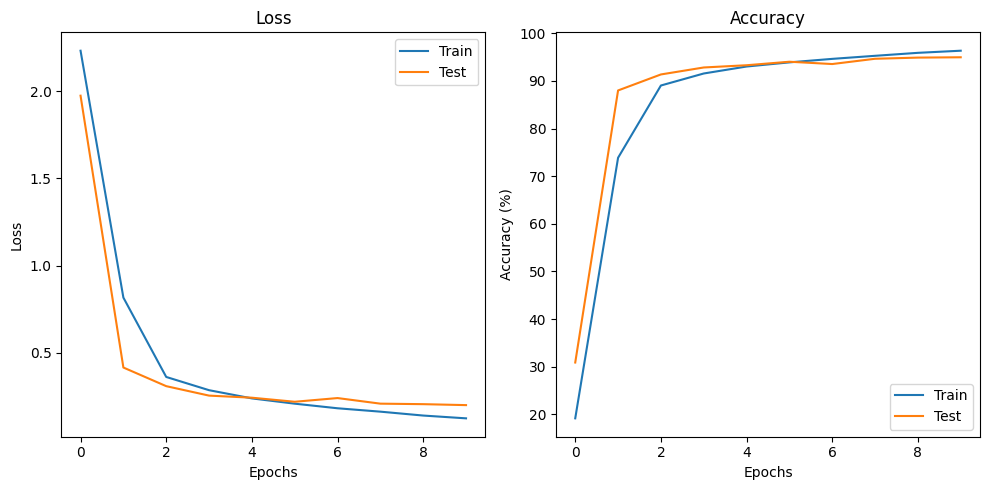

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train')
plt.plot(test_acc_hist, label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()